# Regular Bert Training with Early Stopping

## 0. Setup

### 0.1 Install libraries

In [1]:
! pip install -r requirements.txt

# If you work with GPU-support (CUDA 12.8):
! pip install torch==2.7.1+cu128 -f https://download.pytorch.org/whl/torch/
! pip install torchaudio==2.7.1+cu128 -f https://download.pytorch.org/whl/torchaudio/
! pip install torchvision==0.22.1+cu128 -f https://download.pytorch.org/whl/torchvision/

# If you only work with CPU-support:
# ! pip install torch==2.7.1
# ! pip install torchaudio==2.7.1
# ! pip install torchvision==0.22.1


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in links: https://download.pytorch.org/whl/torch/



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in links: https://download.pytorch.org/whl/torchaudio/



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in links: https://download.pytorch.org/whl/torchvision/



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 0.2 GPU setup

In [2]:
# Check if CUDA is available and print the current device's name
import torch
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(0))

True
0
NVIDIA GeForce RTX 3070


## 1 Configuration

In [3]:
# Data variables
data_path = "../../data/training_data/labeled/labeled_data.xlsx" # path to the Excel file with the labeled data
results_path = "../../data/model_performance" # path to where the results should be stored
text_column_name = "expanded" # name of the column containing the text to classify
label_column_name = "label" # name of the column containing the labels (0 = correct or 1 = incorrect)
num_labels = 2 # binary classification (see above)

# Model configuration
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract" # "bert-base-uncased" for standard BERT; "allenai/scibert_scivocab_uncased" for SciBERT and "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract" for PubMedBERT
test_size = 0.2 # ratio of the dataset to be used for testing
validation_size = 0.1 # ration of the training set (80%) to be used for validation (model evaluation after each epoch)
max_length = 256 # maximum length of the input sequences for BERT
num_epochs = 10 # number of epochs for training
batch_size = 32 # batch size for training and evaluation
learning_rate = 2e-5 # learning rate for the optimizer
weight_decay = 0.01 # weight decay for the optimizer
early_stopping_patience = 2 # number of epochs with no improvement after which training will be stopped
save_checkpoints = False # if 'FALSE', deletes all saved checkpoints at the end of the script

# Seed for reproducibility
import random
import numpy as np
from transformers import set_seed
import os

seed = 42

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
set_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

d:\OneDrive\Dokumente\GitHub Desktop\nonsig-master-thesis\nonsig_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2 Read and prepare dataset

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Load the data
df = pd.read_excel(data_path)

# Remove all columns but 'expanded' and 'label_strict'
df = df.drop(columns=['statement_id', 'section', 'header','div', 'p', 's', 'article_id', 'p_comp', 'p_value', 'context', 'text', 'label_keywords', 'label_comment'])

# Change column names
df = df.rename(columns={text_column_name: 'text', label_column_name: 'label'})

# Remove rows where 'label' is NA
df = df[df['label'].notna()]

# Remove rows where 'label' is -99
df = df[df['label'] != -99]

# Convert label column to int (required for classification)
df['label'] = df['label'].astype(int)

# Balance labels via undersampling (generalized)
label_counts = df['label'].value_counts()  # Get counts of each label
minority_label = label_counts.idxmin() # Get the minority label
majority_label = label_counts.idxmax() # Get the majority label

df_minority = df[df['label'] == minority_label]
df_majority = df[df['label'] == majority_label]

df_majority_downsampled = resample( # Downsample majority label
    df_majority,
    replace=False,
    n_samples=len(df_minority),
    random_state=seed
)

df = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=seed).reset_index(drop=True)

# Check label balance in data
print("Training label distribution:")
print(df['label'].value_counts())

Training label distribution:
label
0    352
1    352
Name: count, dtype: int64


### 2.1 Create train & validation set and test set

In [5]:
from sklearn.model_selection import train_test_split

# Put 20 % of the data into a test set, for evaluation at the end
train_df, test_df = train_test_split(df, test_size=test_size, stratify=df['label'], random_state=seed)

# Put 10 % of the training data into a test set, for evaluation at the end
train_df, validation_df = train_test_split(train_df, test_size=validation_size, stratify=train_df['label'], random_state=seed)

# Convert to Huggingface dataset
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df)
validation_dataset = Dataset.from_pandas(validation_df)
test_dataset = Dataset.from_pandas(test_df)

#### 2.1.1 Label balance in all three datasets

In [6]:
# training set
print("Training label distribution:")
print(train_df['label'].value_counts())

# validation set
print("Validation label distribution:")
print(validation_df['label'].value_counts())

# test set
print("Test label distribution:")
print(test_df['label'].value_counts())

Training label distribution:
label
1    253
0    253
Name: count, dtype: int64
Validation label distribution:
label
1    29
0    28
Name: count, dtype: int64
Test label distribution:
label
0    71
1    70
Name: count, dtype: int64


### 2.2 Tokenize 'text'

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_for_bert(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=max_length)

tokenized_train = train_dataset.map(tokenize_for_bert, batched=True)

tokenized_validation = validation_dataset.map(tokenize_for_bert, batched=True)

tokenized_test = test_dataset.map(tokenize_for_bert, batched=True)

d:\OneDrive\Dokumente\GitHub Desktop\nonsig-master-thesis\nonsig_venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\raphi\.cache\huggingface\hub\models--microsoft--BiomedNLP-PubMedBERT-base-uncased-abstract. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Map: 100%|██████████| 141/141 [00:00<00:00, 71

## 3 Train BERT

### 3.1 Initializing model

In [8]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3.2 Training regular BERT

In [9]:
# Standard Setup for training a model with Huggingface Transformers
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import EarlyStoppingCallback
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

training_args = TrainingArguments(
    output_dir="./results/PubMedBERT",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=weight_decay,
    logging_strategy="epoch",
    report_to="none",
    save_strategy="epoch",
    eval_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model = "eval_loss",
    seed=seed
)

# Model specific setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_validation,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)]  # Stop training if no improvement after 2 epochs
)

C:\Users\raphi\AppData\Local\Temp\ipykernel_9500\56877117.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [10]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.679400,0.624125,0.666667,0.666667,0.689655,0.677966
2,0.505100,0.501261,0.771930,0.900000,0.620690,0.734694
3,0.316400,0.347060,0.842105,0.916667,0.758621,0.830189
4,0.150400,0.220543,0.929825,0.931034,0.931034,0.931034
5,0.089100,0.190627,0.947368,1.000000,0.896552,0.945455
6,0.030100,0.239664,0.912281,0.928571,0.896552,0.912281
7,0.015500,0.330845,0.912281,0.961538,0.862069,0.909091


TrainOutput(global_step=112, training_loss=0.2551391050219536, metrics={'train_runtime': 567.6988, 'train_samples_per_second': 8.913, 'train_steps_per_second': 0.282, 'total_flos': 465969679042560.0, 'train_loss': 0.2551391050219536, 'epoch': 7.0})

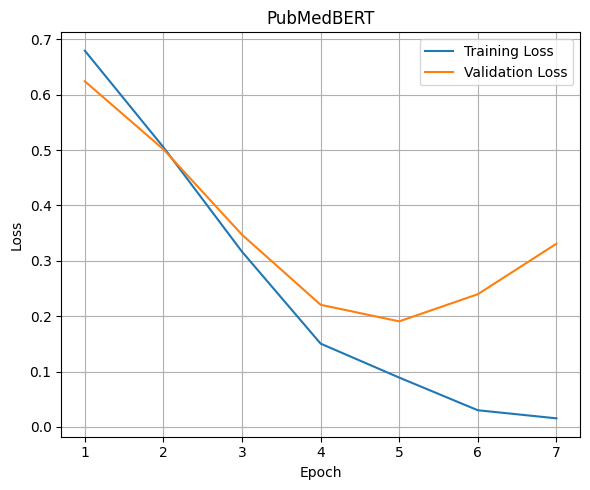

In [ ]:
# Visualize loss curves
import matplotlib.pyplot as plt

# Extract training log history
logs = pd.DataFrame(trainer.state.log_history)

# Filter for loss values
loss_logs = logs[logs["loss"].notnull()][["epoch", "loss"]]
eval_logs = logs[logs["eval_loss"].notnull()][["epoch", "eval_loss"]]

# Plotting
# Plotting
plt.figure(figsize=(6, 5))
plt.plot(loss_logs["epoch"], loss_logs["loss"], label="Training Loss")
plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], label="Validation Loss")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.title("PubMedBERT", fontsize=18, fontweight='bold')
plt.ylim(0, 0.8)
# plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()

# Save the figure
from pathlib import Path
plt.savefig((save_path := Path(results_path) / "loss_curve").mkdir(parents=True, exist_ok=True) or save_path / "PubMedBERT.pdf", dpi=300, bbox_inches='tight')

plt.show()

#### 3.2.1 Save last model

In [12]:
# Save the best model and tokenizer
trainer.save_model("./best_model/PubMedBERT")
tokenizer.save_pretrained("./best_model/PubMedBERT")

('./best_model/PubMedBERT\\tokenizer_config.json',
 './best_model/PubMedBERT\\special_tokens_map.json',
 './best_model/PubMedBERT\\vocab.txt',
 './best_model/PubMedBERT\\added_tokens.json',
 './best_model/PubMedBERT\\tokenizer.json')

### 3.3 Evaluate model

#### 3.3.1 Predict training data

In [13]:
from sklearn.metrics import classification_report

train_preds = trainer.predict(tokenized_train)
train_preds = np.argmax(train_preds.predictions, axis=1)
GT_train = train_df['label'].tolist()
print("Training Classification Report:")
print(classification_report(GT_train, train_preds))

Training Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       253
           1       1.00      0.99      1.00       253

    accuracy                           1.00       506
   macro avg       1.00      1.00      1.00       506
weighted avg       1.00      1.00      1.00       506



#### 3.3.2 Predict test data

In [14]:
# In case you want to change the threshold for classification, you can do so here:
# threshold = 0.5



In [15]:
test_preds = trainer.predict(tokenized_test)
test_preds = np.argmax(test_preds.predictions, axis=1)
GT_test = test_df['label'].tolist()
print("Test Classification Report:")
print(classification_report(GT_test, test_preds))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        71
           1       0.91      0.90      0.91        70

    accuracy                           0.91       141
   macro avg       0.91      0.91      0.91       141
weighted avg       0.91      0.91      0.91       141



In [16]:
# Save test results in 'classification_report.csv'

# Get classification report as a dict
report_dict = classification_report(GT_test, test_preds, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Optionally reset index for nicer format
report_df = report_df.reset_index().rename(columns={"index": "class"})

# Save to CSV if you want
from pathlib import Path
report_df.to_csv((report_path := Path(results_path) / "classification_report").mkdir(parents=True, exist_ok=True) or report_path / "PubMedBERT.csv", index=False)

**Confusion-Matrix for test data:**

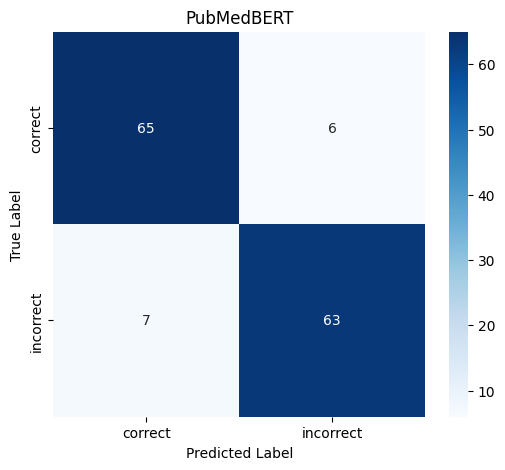

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Create confusion matrix
conf_matrix = confusion_matrix(GT_test, test_preds)

plt.figure(figsize=(6, 5))
heatmap = sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    vmin=0,
    vmax=70,
    xticklabels=["correct", "incorrect"],
    yticklabels=["correct", "incorrect"],
    annot_kws={"size": 16},                     # Font size inside cells
    cbar_kws={"label": "Count"}                 # Colorbar label
)

# Increase font size for colorbar label and ticks
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=14)           # Tick labels on colorbar
colorbar.set_label("Count", size=16)            # Colorbar label font size

# Axis labels and title
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.title('PubMedBERT', fontsize=18, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()

# Save the figure
plt.savefig((save_path := Path(results_path) / "confusion_matrix").mkdir(parents=True, exist_ok=True) or save_path / "PubMedBERT.pdf", dpi=300, bbox_inches='tight')

plt.show()

**F1 Score**

In [18]:
from sklearn.metrics import f1_score
print(f"Test F1 score: {f1_score(GT_test, test_preds):.3f}")

Test F1 score: 0.906


#### 3.3.4 List of statements per category (TP, TN, FP, FN)

In [19]:
# Get ground truth and predictions for test set
y_true = test_df['label'].tolist()
y_pred = test_preds

# True Positives: predicted 1, actual 1
true_positives = test_df[(test_df['label'] == 1) & (y_pred == 1)]

# True Negatives: predicted 0, actual 0
true_negatives = test_df[(test_df['label'] == 0) & (y_pred == 0)]

# False Positives: predicted 1, actual 0
false_positives = test_df[(test_df['label'] == 0) & (y_pred == 1)]

# False Negatives: predicted 0, actual 1
false_negatives = test_df[(test_df['label'] == 1) & (y_pred == 0)]

# Function to print statements
import pandas as pd
from IPython.display import display

def display_statements(df, title):
    if not df.empty:
        print(f"\n{title} (count: {len(df)})")
        display(df[['text']].reset_index(drop=True))
    else:
        print(f"\n{title}: None")

In [20]:
display_statements(true_positives, "True Positives (predicted 1, actual 1)")


True Positives (predicted 1, actual 1) (count: 63)


,text
0,No such increase was observed in the incongrue...
1,"In contrast, there was no difference between t..."
2,"When both targets were available, observers sw..."
3,"First, participant height (added as a fixed fa..."
4,Efficiency did not differ between the congruen...
...,...
58,Follow-up analyses showed that there was no Tr...
59,There was no difference in the ratings given t...
60,"Also, when the analyses were limited to biased..."
61,"There was no effect of search condition, F(1, ..."


In [21]:
display_statements(true_negatives, "True Negatives (predicted 0, actual 0)")


True Negatives (predicted 0, actual 0) (count: 65)


,text
0,"Again, results indicated that endorsement of d..."
1,Results revealed no significant relationship b...
2,Leader narcissism levels also did not signific...
3,"Moreover, a second model-intended to ascertain..."
4,"Overall, RT was on average slower when sounds ..."
...,...
60,"When we resolved this interaction, results sho..."
61,We found that sounds did not have a significan...
62,"Again, contrary to expectations, our results r..."
63,Meta-regression indicated no significant moder...


In [22]:
display_statements(false_positives, "False Positives (predicted 1, actual 0)")


False Positives (predicted 1, actual 0) (count: 6)


,text
0,"However, no effect of arousal was found for un..."
1,The main effect of illness recency did not mee...
2,Although the means of the two liking ratings d...
3,"In Experiment 2 (but not Experiment 1), there ..."
4,"As in Experiments 1 and 2, participants' accur..."
5,Results suggested that among the Ackerman stim...


In [23]:
display_statements(false_negatives, "False Negatives (predicted 0, actual 1)")


False Negatives (predicted 0, actual 1) (count: 7)


,text
0,"As before, this interaction resulted from a si..."
1,A two-way mixed ANOVA investigating whether pe...
2,The analysis of the change-detection performan...
3,"However, the absence of a postresponse effect ..."
4,A second analysis to test for the presence of ...
5,When we added hours of practice to the analyse...
6,Our assertion was supported in RTs (classic fa...


## 4 Storing results

### 4.1 Performance over the epochs

In [24]:
# Save log history
log_history = trainer.state.log_history

# Convert to DataFrame
log_df = pd.DataFrame(log_history)

# Save to CSV in 'results_path' folder
log_df.to_csv((log_path := Path(results_path) / "model_training_history").mkdir(parents=True, exist_ok=True) or log_path / "PubMedBERT.csv", index=False)

# Display the first few rows
print(log_df.head())

     loss  grad_norm  learning_rate  epoch  step  eval_loss  eval_accuracy  \
0  0.6794  10.439427       0.000018    1.0    16        NaN            NaN   
1     NaN        NaN            NaN    1.0    16   0.624125       0.666667   
2  0.5051   8.240020       0.000016    2.0    32        NaN            NaN   
3     NaN        NaN            NaN    2.0    32   0.501261       0.771930   
4  0.3164  20.410501       0.000014    3.0    48        NaN            NaN   

   eval_precision  eval_recall   eval_f1  eval_runtime  \
0             NaN          NaN       NaN           NaN   
1        0.666667     0.689655  0.677966        0.4780   
2             NaN          NaN       NaN           NaN   
3        0.900000     0.620690  0.734694        0.3107   
4             NaN          NaN       NaN           NaN   

   eval_samples_per_second  eval_steps_per_second  train_runtime  \
0                      NaN                    NaN            NaN   
1                  119.255                  4.

### 4.2 Final performance on test set

In [25]:
# Save human and BERT labels on test set
predictions_df = pd.DataFrame({
    "statement": test_df['text'],
    "human_label": GT_test,
    "BERT_label": test_preds
})
predictions_df.to_csv((pred_path := Path(results_path) / "test_predictions").mkdir(parents=True, exist_ok=True) or pred_path / "PubMedBERT.csv", index=False)

In [26]:
import glob
import shutil

# If save_checkpoints is False, delete all checkpoint folders
if save_checkpoints is False:
    checkpoint_paths = glob.glob('./results/PubMedBERT/checkpoint-*')
    for path in checkpoint_paths:
        shutil.rmtree(path)  # Remove the entire folder and contents
        print(f"Removed {path}")

Removed ./results/PubMedBERT\checkpoint-112
Removed ./results/PubMedBERT\checkpoint-16
Removed ./results/PubMedBERT\checkpoint-32
Removed ./results/PubMedBERT\checkpoint-48
Removed ./results/PubMedBERT\checkpoint-64
Removed ./results/PubMedBERT\checkpoint-80
Removed ./results/PubMedBERT\checkpoint-96


In [27]:
# The end...